In [1]:
# Use google drive for loading dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from scipy.io import loadmat
import cv2
from PIL import Image

# **Data Preprocessing:**

In [3]:
# Image
train_img_folder = '/content/drive/MyDrive/Datasets/train/img'
val_img_folder = '/content/drive/MyDrive/Datasets/val/img'

# masks
masks_folder = '/content/drive/MyDrive/Datasets/trainval'

# labels
labels_file = '/content/drive/MyDrive/Datasets/labels.txt'

# other settings
image_size = 256

In [58]:
labels = {}
with open(labels_file, 'r') as file:
    for line in file:
        color_code, label = line.strip().split(':')
        # print(color_code, '=', label)
        labels[int(color_code)] = label.strip()


In [59]:
labels

{1: 'accordion',
 2: 'aeroplane',
 3: 'air conditioner',
 4: 'antenna',
 5: 'artillery',
 6: 'ashtray',
 7: 'atrium',
 8: 'baby carriage',
 9: 'bag',
 10: 'ball',
 11: 'balloon',
 12: 'bamboo weaving',
 13: 'barrel',
 14: 'baseball bat',
 15: 'basket',
 16: 'basketball backboard',
 17: 'bathtub',
 18: 'bed',
 19: 'bedclothes',
 20: 'beer',
 21: 'bell',
 22: 'bench',
 23: 'bicycle',
 24: 'binoculars',
 25: 'bird',
 26: 'bird cage',
 27: 'bird feeder',
 28: 'bird nest',
 29: 'blackboard',
 30: 'board',
 31: 'boat',
 32: 'bone',
 33: 'book',
 34: 'bottle',
 35: 'bottle opener',
 36: 'bowl',
 37: 'box',
 38: 'bracelet',
 39: 'brick',
 40: 'bridge',
 41: 'broom',
 42: 'brush',
 43: 'bucket',
 44: 'building',
 45: 'bus',
 46: 'cabinet',
 47: 'cabinet door',
 48: 'cage',
 49: 'cake',
 50: 'calculator',
 51: 'calendar',
 52: 'camel',
 53: 'camera',
 54: 'camera lens',
 55: 'can',
 56: 'candle',
 57: 'candle holder',
 58: 'cap',
 59: 'car',
 60: 'card',
 61: 'cart',
 62: 'case',
 63: 'casette r

4950it [00:52, 93.69it/s]


 filename: 2008_004074


Text(0.5, 1.0, 'mask: (256, 256)')

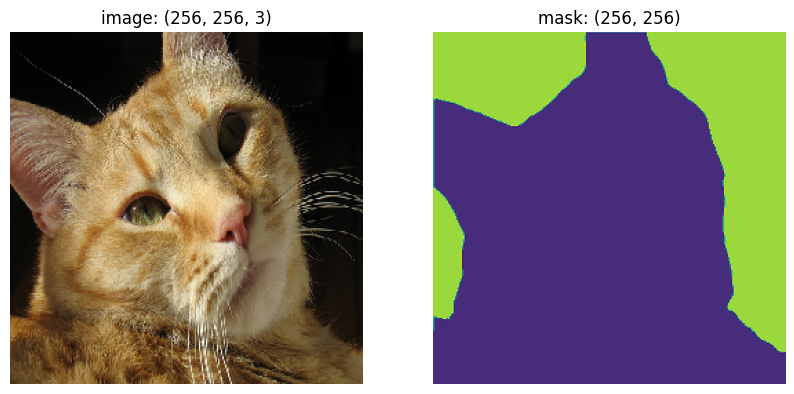

In [6]:
train_images = []
train_masks = []
nt = 4950

for i, file_name1 in tqdm(enumerate(os.listdir(train_img_folder))):
    if file_name1.endswith('.jpeg'):
      
        if i >= nt:
            break

        img = load_img(os.path.join(train_img_folder, file_name1), target_size=(image_size, image_size))
        img = img_to_array(img)
        img = img / 255.0

        image_name1 = os.path.splitext(file_name1)[0]

        mask = loadmat(os.path.join(masks_folder, image_name1 + '.mat'))['LabelMap']
        mask = cv2.resize(mask, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        train_images.append(img)
        train_masks.append(mask)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

print('\n', 'filename:', image_name1)
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
plt.imshow(train_images[-1]) # show last image
plt.axis('off')
plt.title(f"image: {train_images[-1].shape}")

fig.add_subplot(1, 2, 2)
plt.imshow(train_masks[-1]) # show last mask
plt.axis('off')
plt.title(f"mask: {train_masks[-1].shape}")


In [ ]:
train_images.shape

3000it [00:00, 4024.88it/s]


 filename: 2008_004278


Text(0.5, 1.0, 'mask: (256, 256)')

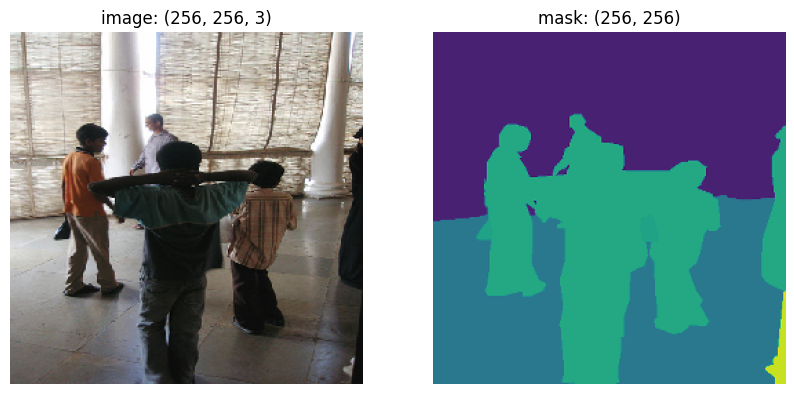

In [7]:
val_images = []
val_masks = []
nv = 3000

for i, file_name2 in tqdm(enumerate(os.listdir(val_img_folder))):
    if file_name2.endswith('.jpeg'):
        
        if i >= nv:
            break
        
        img = load_img(os.path.join(val_img_folder, file_name2), target_size=(image_size, image_size))
        img = img_to_array(img)
        img = img / 255.0

        image_name2 = os.path.splitext(file_name2)[0]

        mask = loadmat(os.path.join(masks_folder, image_name2 + '.mat'))['LabelMap']
        mask = cv2.resize(mask, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)

        val_images.append(img)
        val_masks.append(mask)
        
val_images = np.array(val_images)
val_masks = np.array(val_masks)

print('\n', 'filename:', image_name2)
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)
plt.imshow(val_images[-1]) # show last image
plt.axis('off')
plt.title(f"image: {val_images[-1].shape}")

fig.add_subplot(1, 2, 2)
plt.imshow(val_masks[-1]) # show last mask
plt.axis('off')
plt.title(f"mask: {val_masks[-1].shape}")


In [ ]:
val_images.shape

# **U-Net Model:**

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(256, 256, 3), n_classes=509):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model



# **Fit Model:**

In [10]:
# Define the U-Net model
model = unet_model()

print()
print()

# Train the model
model.fit(
      train_images,
      train_masks,
      validation_data=(val_images, val_masks),
      epochs=10,
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

# **Predict Model:**

(1, 256, 256, 3)


(-0.5, 255.5, 255.5, -0.5)

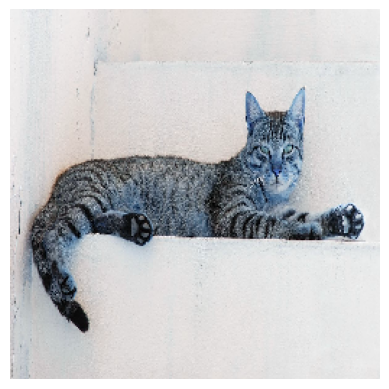

In [69]:
# Load a new image for prediction
test_image_path = '/content/test.jpg'
new_image = load_img(test_image_path, target_size=(image_size, image_size))
new_image_array = np.expand_dims(new_image, axis=0) / 255.0

print(new_image_array.shape)
plt.imshow(new_image_array[0, :, :, ::-1])
plt.axis('off')

In [70]:
# Predict the mask
predicted_mask = model.predict(new_image_array)
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

predicted_mask.shape

1/1 [==============================] - 2s 2s/step


(1, 256, 256, 509)

In [64]:
for c in np.unique(predicted_mask):
    print(f"we have {labels.get(int(c)).upper()} in this image!")

we have CAT in this image!


In [ ]:
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.title('Input Image')
# plt.imshow(new_image_array[0, :, :, ::-1])

# plt.subplot(1, 2, 2)
# plt.title('Predicted Mask')
# plt.imshow(predicted_mask[0, :, :, 0])

# plt.show()